In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
import pickle
import sklearn.metrics as metrics

In [2]:
import sys
import os

from DEBtoolPyIF.estimation.problem import DEBModelParametrizationProblem


# Add the 'project' directory to the path
sys.path.append(os.path.abspath('..'))

from project_code.data.load_data import load_col_types, load_data
from project_code.data.prepare_data_sklearn import get_features_targets, get_single_output_col_types
from project_code.utils.results import get_best_model_file
from project_code.evaluate.score import mean_deb_loss

# Loading data

In [3]:
# dataset_name = 'no_pub_weight'
# dataset_name = 'ratio_no_pub_weight'
dataset_name = 'ratio_output_no_pub_weight'
# dataset_name = 'bijection_input'

dataset_name += '_taxonomy'
dataset_name += '_ecocodes'

# Load the data
dataset_folder = f'../data/processed/'
results_folder = f'../results/{dataset_name}'
dfs = load_data(dataset_name=dataset_name, data_split='train_test', dataset_folder=dataset_folder)
col_types = load_col_types(dataset_name=dataset_name, dataset_folder=dataset_folder)
data = get_features_targets(dfs, col_types)

In [4]:
dfs['train']

,ab,ap,am,d_V,Wwb,Wwi,Ri,T_typical,metamorphosis,weaning,...,habitat_T,habitat_F,habitat_S,habitat_M,migrate_T,food_other,food_P,food_O,food_H,food_C
species,,,,,,,,,,,,,,,,,,,,,
Bufo_japonicus,20.972960,1193.104000,5274.5900,0.28,0.00420,417.0,5.605175,288.15,False,False,...,True,True,False,False,False,False,False,True,False,True
Geronticus_eremita,4.325449,11.269940,1853.1750,0.28,37.00000,1202.0,0.053260,312.15,False,False,...,True,False,False,False,False,False,False,False,False,True
Archboldia_papuensis,5.409842,15.990460,665.8494,0.28,17.00000,125.0,0.022528,314.75,False,False,...,True,False,False,False,False,False,False,False,True,True
Gopherus_agassizii,47.965280,3857.071000,15874.9700,0.30,27.50000,2473.0,0.031647,297.15,False,False,...,True,False,False,False,False,False,False,False,True,False
Chlorodrepanis_virens,2.858030,10.155010,532.6795,0.28,1.30000,12.0,0.084479,314.75,False,False,...,True,False,False,False,False,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Threskiornis_aethiopicus,4.413723,10.200800,2084.1180,0.28,39.50000,1424.5,0.039767,312.15,False,False,...,False,True,False,False,False,False,False,False,False,True
Umbra_krameri,37.946620,923.025100,2603.1720,0.20,0.00260,26.9,2.881100,288.15,False,False,...,False,True,False,False,False,False,False,False,False,True
Corydoras_aeneus,1.898303,96.813460,1154.8010,0.20,0.00064,3.2,2.597850,298.15,True,False,...,False,True,False,False,False,False,False,False,True,True


In [5]:
categories = ['class', 'climate', 'habitat', 'migrate', 'food']
for df in dfs.values():
    df['model'] = 'std'
    df.loc[df['weaning'], 'model'] = 'stx'
    df.loc[df['metamorphosis'], 'model'] = 'abj'
    for cat in categories:
        cat_cols = [col for col in df.columns if cat in col]
        if not len(cat_cols):
            continue
        df[cat] = ''
        for i, row in df.iterrows():
            for cat_opt in cat_cols:
                if row[cat_opt]:
                    df.loc[i, cat] = cat_opt
                    break
            #else:
            #    row[cat] = 'None'
            

        # Clean up the resulting column (if needed, e.g., removing the 'Category_' prefix)
        df[cat] = df[cat].str.replace(f"{cat}_", '')
dfs['test']

,ab,ap,am,d_V,Wwb,Wwi,Ri,T_typical,metamorphosis,weaning,...,food_P,food_O,food_H,food_C,model,class,climate,habitat,migrate,food
species,,,,,,,,,,,,,,,,,,,,,
Acanthis_flammea,2.041450,6.054789,541.5575,0.28,1.3000,14.200,0.225276,314.75,False,False,...,False,False,True,True,std,Aves,D,T,,H
Dendrocolaptes_platyrostris,3.062175,9.629457,443.8996,0.28,9.0000,60.700,0.067583,314.75,False,False,...,False,False,False,True,std,Aves,A,T,,C
Phacellodomus_ruber,3.470465,8.578351,443.8996,0.28,11.5000,37.000,0.090110,314.75,False,False,...,False,False,False,True,std,Aves,A,T,,C
Trachycephalus_resinifictrix,4.847953,384.027100,5561.2940,0.28,0.0018,71.000,9.889784,297.15,False,False,...,False,False,False,True,std,Amphibia,A,T,,C
Hydrobates_pelagicus,15.483590,25.205880,1903.8700,0.28,5.0000,46.000,0.017753,312.15,False,False,...,False,False,False,True,std,Aves,,M,,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Rallus_elegans,4.936178,9.316707,1188.5110,0.28,14.7000,340.000,0.185753,312.75,False,False,...,False,False,True,True,std,Aves,C,F,,H
Emys_orbicularis,42.140490,1390.324000,30334.3300,0.30,5.0000,2275.831,0.035603,297.15,False,False,...,False,False,True,True,std,Reptilia,B,T,,H
Pristis_perotteti,105.616100,2254.298000,7583.5830,0.20,1143.6750,591000.000,0.014439,297.15,False,False,...,False,False,False,True,std,other,A,F,,C


In [6]:
def load_best_model(col, model_type):
    col_results_folder = f"{results_folder}/{col}"
    model_file = get_best_model_file(col_results_folder, model_type=model_type)
    if model_file is None:
        return None
    with open(f"{col_results_folder}/models/{model_file}", 'rb') as f:
        best_model = pickle.load(f)
    return best_model

# Loading Best Models

In [7]:
model_types = ['Ridge', 'Lasso', 'RandomForestRegressor', 'SVR', 'XGBRegressor']
best_models = {}
for mt in model_types:
    best_models[mt] = {}
    for col in col_types['output']['all']:
        best_models[mt][col] = load_best_model(col, mt)

In [9]:
rf_hyperpars = ['n_estimators', 'min_samples_split', 'max_features', 'criterion']
for i, col in enumerate(col_types['output']['all']):
    #rf = load_best_model(col, 'RandomForestRegressor')
    rf = best_models['RandomForestRegressor'][col]
    hyperpars_dict = {hp: rf.regressor_.get_params()[hp] for hp in rf_hyperpars}
    print(f"'{col}': {hyperpars_dict},")

'p_Am': {'n_estimators': 8400, 'min_samples_split': 5, 'max_features': 19, 'criterion': 'friedman_mse'},
'kap': {'n_estimators': 7100, 'min_samples_split': 2, 'max_features': 13, 'criterion': 'friedman_mse'},
'v': {'n_estimators': 100, 'min_samples_split': 6, 'max_features': 30, 'criterion': 'friedman_mse'},
'p_M': {'n_estimators': 8300, 'min_samples_split': 2, 'max_features': 8, 'criterion': 'friedman_mse'},
'h_a': {'n_estimators': 2700, 'min_samples_split': 5, 'max_features': 20, 'criterion': 'squared_error'},
'E_Hb_p': {'n_estimators': 6600, 'min_samples_split': 4, 'max_features': 7, 'criterion': 'friedman_mse'},
'E_Hp': {'n_estimators': 8600, 'min_samples_split': 2, 'max_features': 13, 'criterion': 'squared_error'},


# Model Predictions

In [30]:
def plot_residuals(model_type, plot_kind, groupby, scale):
    n_cols = 4
    fig, axes = plt.subplots(nrows=2, ncols=n_cols, figsize=(20, 10), tight_layout=True)
    fig.suptitle(model_type, fontsize=16)
    margin_factor = 0.05

    X = data['test']['input']
    for i, col in enumerate(col_types['output']['all']):
        model = best_models[model_type][col]
        ax = axes[i // n_cols, i % n_cols]

        scaled_y_pred = model.predict(data['test']['input'])

        if scale == 'model':
            scaled_y_true = model.output_transformer.transform(data['test']['output'][:, i])
            pred_values = scaled_y_pred
            actual_values = scaled_y_true
            
        elif scale == 'real':
            actual_values = data['test']['output'][:, i]
            pred_values = model.output_transformer.inverse_transform(scaled_y_pred)
            if col in col_types['output']['log']:
                ax.set_xscale('log')
                #if plot_kind == 'residual_vs_predicted':
                    #ax.set_yscale('symlog')
                if plot_kind == 'actual_vs_predicted':
                    ax.set_yscale('log')
        
        min_v = (1-margin_factor)*min(actual_values.min(), pred_values.min())
        max_v = (1+margin_factor)*max(actual_values.max(), pred_values.max())
        ax.set_xlim([min_v, max_v])

        if plot_kind == 'residual_vs_predicted':
            if scale == 'model':
                residuals = actual_values - pred_values
            if scale == 'real':
                residuals = (actual_values - pred_values) / actual_values
            sns.scatterplot(x=pred_values, y=residuals, ax=ax, hue=dfs['test'][groupby])
            ax.plot([min_v, max_v], [0, 0], 'k--')
            ax.set_ylabel('Residuals (actual - predicted)')

        elif plot_kind == 'actual_vs_predicted':
            sns.scatterplot(x=pred_values, y=actual_values, ax=ax, hue=dfs['test'][groupby])
            
            ax.set_ylim([min_v, max_v])
            ax.plot([min_v, max_v], [min_v, max_v], 'k--')
            ax.set_ylabel('Actual values')

        ax.set_xlabel('Predicted values')
            
        
        # metrics.PredictionErrorDisplay.from_estimator(estimator=model, X=X, y=scaled_y_true, kind=plot_kind, ax=ax)
        ax.set_title(col)
    axes[1,3].remove()

model_selector = widgets.Dropdown(options=model_types, value='RandomForestRegressor', description='Model:')
plot_selector = widgets.Dropdown(options=['actual_vs_predicted', 'residual_vs_predicted'], value='actual_vs_predicted', description='Plot Type:')
groupby_selector = widgets.Dropdown(options=['model', 'class', 'climate', 'habitat', 'migrate', 'food'])
scale_selector = widgets.Dropdown(options=['model', 'real',])
widgets.interactive(plot_residuals, model_type=model_selector, plot_kind=plot_selector, groupby=groupby_selector, scale=scale_selector)

interactive(children=(Dropdown(description='Model:', index=2, options=('Ridge', 'Lasso', 'RandomForestRegresso…

# Feature importance

## Random Forests

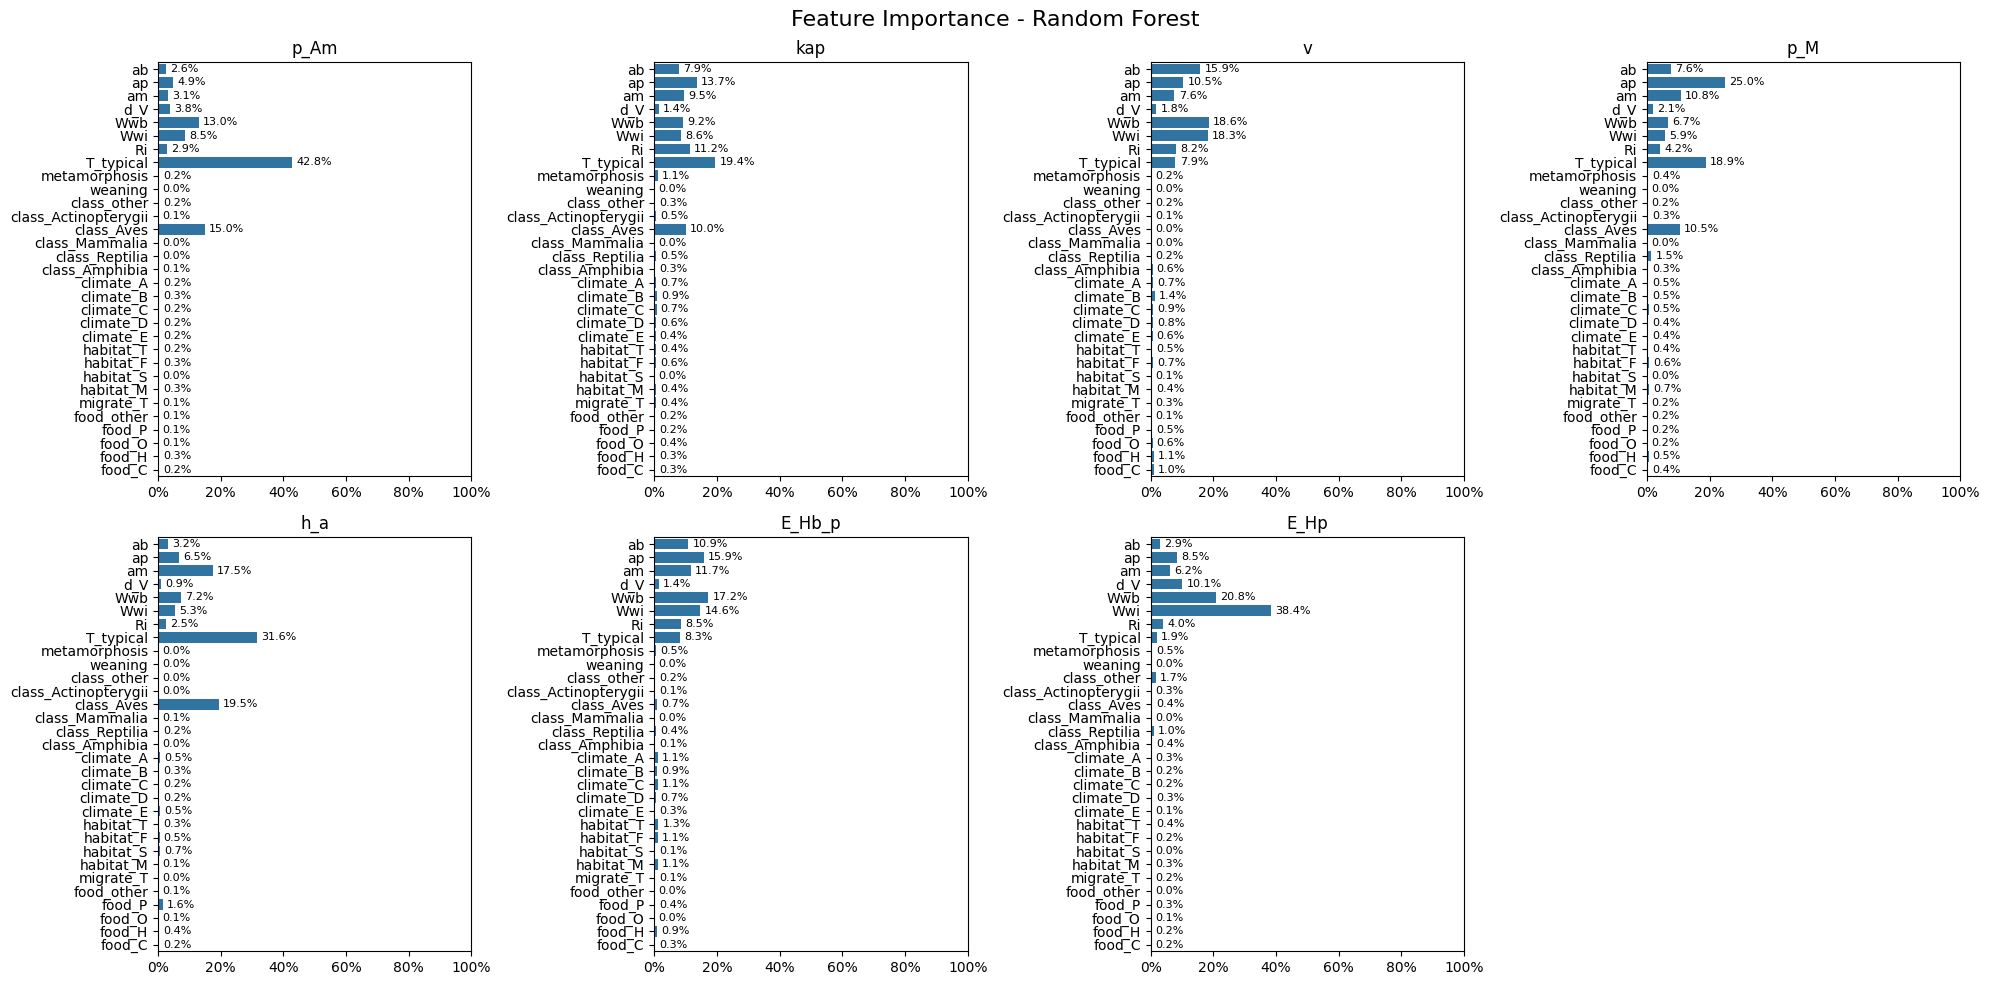

In [20]:
n_cols = 4
fig, axes = plt.subplots(nrows=2, ncols=n_cols, figsize=(20, 10), tight_layout=True)
fig.suptitle('Feature Importance - Random Forest', fontsize=16)
for i, col in enumerate(col_types['output']['all']):
    importances = pd.DataFrame({'importance': best_models['RandomForestRegressor'][col].regressor_.feature_importances_*100,
                                'input_col': col_types['input']['all']})
    ax = axes[i // n_cols, i % n_cols]
    sns.barplot(data=importances, y='input_col', x='importance', ax=ax)
    ax.set_title(col)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xlim([0, 100])
    # Set x-axis format to percentage using PercentFormatter
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
    
    # Add percentage labels on bars using ax.bar_label()
    ax.bar_label(ax.containers[0], fmt='%.1f%%', label_type='edge', padding=3, fontsize=8)
axes[1,3].remove()


# Parameter Predictions

In [14]:
def predict_E_G_from_theory(d_V):
    kap_G = 0.8
    mu_V = 500_000
    w_V = 23.9
    
    return mu_V * d_V / (kap_G * w_V)

In [16]:
def get_prediction_and_error_df(models):
    feas_df = pd.DataFrame(index=list(dfs['test'].index.values) + list(dfs['train'].index.values), columns=col_types['output']['all'] + se_cols, dtype='float')
    
    # Compute parameter predictions and error
    for split in ('train', 'test'):
        feas_df.loc[dfs[split].index, 'data_split'] = split
        for i, col in enumerate(col_types['output']['all']):
            so_col_types = get_single_output_col_types(col_types=col_types, output_col=col)
            so_data = get_features_targets(data=dfs, col_types=so_col_types)
            
            y_pred = models[col].predict(so_data[split]['input'])
            y_pred_unscaled = models[col].output_transformer.inverse_transform(y_pred)
            y_true = models[col].output_transformer.transform(so_data[split]['output'])
            feas_df.loc[dfs[split].index, col] = y_pred_unscaled
            feas_df.loc[dfs[split].index, f'{col}_se'] = np.power(y_true - y_pred, 2)
    feas_df['mse'] = feas_df[se_cols].mean(axis=1)    
    return feas_df



In [17]:
rf_pred_df = get_prediction_and_error_df(best_models['RandomForestRegressor'])
rf_pred_df

,p_Am,kap,v,p_M,h_a,E_Hb_p,E_Hp,p_Am_se,kap_se,v_se,p_M_se,h_a_se,E_Hb_p_se,E_Hp_se,data_split,mse
Acanthis_flammea,1008.905203,0.923150,0.041804,677.926118,3.712518e-13,0.075013,2973.168006,0.015741,3.516114e-05,0.024046,0.018262,0.043912,1.187632e-04,0.000781,test,0.014699
Dendrocolaptes_platyrostris,1507.583126,0.949709,0.040422,605.228232,2.130267e-12,0.102230,10344.350441,0.000266,9.712000e-03,0.323079,0.000262,0.009005,5.884836e-05,0.164084,test,0.072352
Phacellodomus_ruber,1239.943545,0.941983,0.042226,561.816083,1.362842e-12,0.122515,10290.937729,0.163729,6.414711e-02,0.027233,0.152382,0.022137,1.436723e-02,0.086561,test,0.075794
Trachycephalus_resinifictrix,303.056152,0.782582,0.032181,103.460100,5.420431e-10,0.000844,62651.773785,0.232542,2.725735e-02,0.148865,0.325845,0.009249,5.870989e-07,0.350884,test,0.156377
Hydrobates_pelagicus,3217.575606,0.992134,0.039978,1997.013035,5.589747e-15,0.019991,8319.071066,0.038331,8.501068e-06,0.204221,0.091679,0.005206,7.121567e-05,0.002225,test,0.048820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Threskiornis_aethiopicus,25428.654422,0.997940,0.107384,7431.282159,3.450601e-21,0.005881,49626.017184,0.014907,7.403803e-07,0.002794,0.017924,0.207301,1.493696e-05,0.001441,train,0.034912
Umbra_krameri,99.032996,0.796830,0.034888,27.642586,1.356202e-07,0.002065,1805.514155,0.072388,2.815760e-04,0.000709,0.057940,0.000321,2.415493e-10,0.008027,train,0.019952
Corydoras_aeneus,167.828742,0.966540,0.051318,120.546790,2.957739e-09,0.002355,148.532834,0.005192,2.505858e-04,0.051158,0.001021,0.000809,4.464698e-06,0.001784,train,0.008603
Megascops_choliba,10981.880996,0.995868,0.076927,6141.537954,2.129065e-15,0.010786,15207.528949,0.006187,1.372802e-06,0.072469,0.002509,0.021044,1.487552e-05,0.000120,train,0.014621


In [18]:
par_cols = ['z', 'p_M', 'kap', 'v', 'E_G', 'h_a', 'E_Hb', 'E_Hp']

def get_parameter_prediction(pred_df):
    pars_df = pd.DataFrame(index=pred_df.index, columns=['data_split'] + par_cols, dtype='float')
    pars_df['data_split'] = pred_df['data_split']
    pars_df.index.name = 'species'
    for p in par_cols:
        if p in pred_df.columns:
            pars_df[p] = pred_df[p]
            
    if 'E_Hb' not in pred_df.columns and 'E_Hb_p' in pred_df.columns and 'E_Hp' in pred_df.columns:
        pars_df['E_Hb'] = pred_df['E_Hb_p'] * pred_df['E_Hp']
        
    if 'z' not in pred_df.columns and 'p_Am' in pred_df.columns and 'p_M' in pred_df.columns and 'kap' in pred_df.columns:   
        pars_df['z'] = pred_df['p_Am'] * pred_df['kap'] / pred_df['p_M']
    if 'E_G' not in  pred_df.columns:
        for species in pred_df.index.values:
            pars_df.loc[species, 'E_G'] = predict_E_G_from_theory(dfs[pred_df.loc[species, 'data_split']].loc[species, 'd_V'])
    pars_df[par_cols] = pars_df[par_cols].astype('float')
    return pars_df

In [22]:
rf_pars_df = get_parameter_prediction(rf_pred_df)
rf_pars_df.to_csv(f'{results_folder}/feasibility/RandomForestRegressor_predictions.csv', float_format='%.6e')

# Feasibility

In [31]:
rf_feas_df = pd.read_csv(f'{results_folder}/feasibility/RandomForestRegressor_feasibility.csv', index_col=0)
rf_feas_df

,data_split,feasible,infeasibility_flag,error_message
Row,,,,
Acanthis_flammea,test,1,0,NaN
Dendrocolaptes_platyrostris,test,1,0,NaN
Phacellodomus_ruber,test,0,5,NaN
Trachycephalus_resinifictrix,test,1,0,NaN
Hydrobates_pelagicus,test,1,0,NaN
...,...,...,...,...
Threskiornis_aethiopicus,train,1,0,NaN
Umbra_krameri,train,1,0,NaN
Corydoras_aeneus,train,1,0,NaN


In [39]:
rf_feas_df.loc[rf_feas_df['error_message'] == 'Execution of the future was cancelled.','infeasibility_flag'] = 'timeout'

In [42]:
rf_feas_df[rf_feas_df['data_split'] == 'train']['infeasibility_flag'].value_counts().sort_index()

infeasibility_flag
0          1263
5            29
6             3
timeout      21
Name: count, dtype: int64

In [40]:
rf_feas_df[['data_split', 'feasible', 'infeasibility_flag']].value_counts().sort_index()

data_split  feasible  infeasibility_flag
test        0         5                        6
                      timeout                  1
            1         0                      226
train       0         5                       29
                      6                        3
                      timeout                 21
            1         0                     1263
Name: count, dtype: int64

C:\Users\diogo\AppData\Local\Temp\ipykernel_26692\1291316669.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=train_feasible_counts.values, x=['Feasible', 'Puberty cannot \nbe reached', 'Birth cannot \nbe reached', 'Timeout'], palette=['green'] + 2*['red'] + ['gray'], ax=ax)
C:\Users\diogo\AppData\Local\Temp\ipykernel_26692\1291316669.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=test_feasible_counts.values, x=['Feasible', 'Puberty cannot \nbe reached', 'Timeout'], palette=['green'] + 1*['red'] + ['gray'], ax=ax)


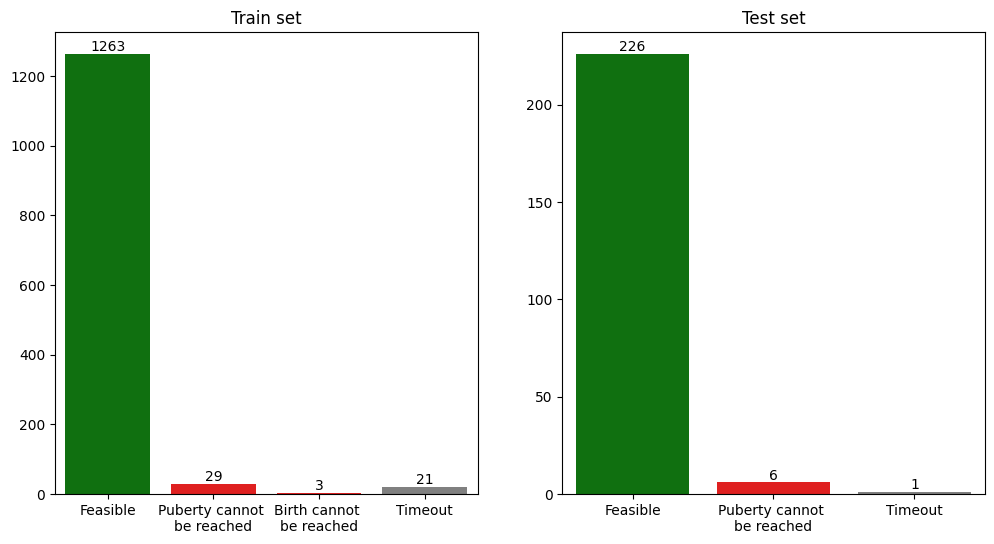

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

ax = axes[0]
train_feasible_counts = rf_feas_df[rf_feas_df['data_split'] == 'train']['infeasibility_flag'].value_counts().sort_index()
sns.barplot(y=train_feasible_counts.values, x=['Feasible', 'Puberty cannot \nbe reached', 'Birth cannot \nbe reached', 'Timeout'], palette=['green'] + 2*['red'] + ['gray'], ax=ax)
ax.set_title('Train set')
for i in range(len(train_feasible_counts)):
    ax.bar_label(ax.containers[i])

ax = axes[1]
test_feasible_counts = rf_feas_df[rf_feas_df['data_split'] == 'test']['infeasibility_flag'].value_counts().sort_index()
sns.barplot(y=test_feasible_counts.values, x=['Feasible', 'Puberty cannot \nbe reached', 'Timeout'], palette=['green'] + 1*['red'] + ['gray'], ax=ax)
ax.set_title('Test set')
for i in range(len(test_feasible_counts)):
    ax.bar_label(ax.containers[i])

### Old code

In [15]:
se_cols = [f'{col}_se' for col in col_types['output']['all']]
from DEBpython.pet import Pet
all_species_folder = r'C:\Users\diogo\OneDrive - Universidade de Lisboa\Terraprima\DEB Resources\DEBtool\AmPdata\species'
"""This class is slow, kept only for future reference."""
class DEBtoolFeasibilityChecker(DEBModelParametrizationProblem):
    def check_pars(self, pars_dict):
        return
    def check_feasibility(self, pars_dict: dict):
        """
        Checks that the parameters are feasible by calling a filter function for the DEB model
        @param pars_dict: A dictionary with the parameters of the problem
        @return: True if the parameter values are a feasible solution, False otherwise
        """
        self.check_pars(pars_dict)
        complete_pars = self.get_complete_pars(pars_dict)
        self.eng.workspace['par'] = complete_pars
        #feasible, flag = self.eng.eval(f"filter_{self.model_type}(par);", nargout=2)
        feasible, flag = self.eng.eval(f"filter_std(par);", nargout=2)
        return bool(feasible), str(int(flag))
        
#species = 'Crassostrea_virginica'
#debtool_feas_checker = DEBtoolFeasibilityChecker(species_name=species, species_folder=f"{all_species_folder}/{species}")

"""This function is very slow and probably has an error. Kept only just in case it is useful in the future."""
def check_feasibility(feas_df):
    # Check feasibility
    pbar = tqdm(feas_df.index.values, desc='Processing species')
    for species in pbar:
        debtool_feas_checker.set_instance(estim_files_dir=f"{all_species_folder}/{species}", species_name=species)
        pars_dict = feas_df.loc[species, col_types['output']['all']].to_dict()
        # Compute absolute values of parameters
        if 'E_Hb_p' in pars_dict:
            pars_dict['E_Hb'] = pars_dict['E_Hb_p'] * pars_dict['E_Hp']
            pars_dict.pop('E_Hb_p')
        # Compute E_G from d_V
        pars_dict['E_G'] = predict_E_G_from_theory(dfs[feas_df.loc[species, 'data_split']].loc[species, 'd_V'])
        
        pars_dict['z'] = pars_dict['p_Am'] * pars_dict['kap'] / pars_dict['p_M']
        feas_df[['feasible', 'reason']] = debtool_feas_checker.check_feasibility(pars_dict)

    return feas_df